In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import itertools
import os
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS


In [3]:
fitness_df = utils.load_fitness_data('../data/fitness_scores_synthetic.csv')
print(fitness_df.shape)
print(fitness_df.src_file.unique())
fitness_df.head()

(17407, 643)
['ast-mle-samples-medium.pddl' 'ast-medium-mle-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,mean_depth_setup,mean_depth_constraints,mean_depth_terminal,mean_depth_scoring,node_count_setup,node_count_constraints,node_count_terminal,node_count_scoring,real,original_game_name
0,0,ast-mle-samples-medium.pddl,game-id-0,medium-objects-room-v1,1.0,0.750000,1.000000,0.0,0.5,0.0,...,5.950000,14.429293,12.602410,0.000000,20,198,83,1,False,game-id-0
1,1,ast-mle-samples-medium.pddl,game-id-1,medium-objects-room-v1,1.0,0.500000,1.000000,0.0,0.0,0.0,...,7.000000,11.550725,2.500000,1.500000,24,69,10,4,False,game-id-1
2,2,ast-mle-samples-medium.pddl,game-id-2,many-objects-room-v1,1.0,0.750000,1.000000,0.0,1.0,0.0,...,7.825397,10.181818,4.941176,3.416667,63,55,17,12,False,game-id-2
3,3,ast-mle-samples-medium.pddl,game-id-3,many-objects-room-v1,1.0,0.500000,0.333333,1.0,1.0,0.0,...,3.285714,11.712919,1.571429,2.923077,14,209,7,13,False,game-id-3
4,4,ast-mle-samples-medium.pddl,game-id-4,few-objects-room-v1,1.0,0.666667,1.000000,0.0,1.0,0.0,...,3.111111,9.047619,6.229885,0.000000,9,42,87,1,False,game-id-4


## Approach in this notebook
* Filter the dataset for the top ~100 of a particular provided feature value
    *  Perhaps with some warning when there are a lot more than those top-k at the cutoff value?
* Fit a fitness model to those
* See that the correct feature scored as expected


In [4]:
def base_syntethic_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('ast-mle-samples-medium.pddl', 'ast-medium-mle-regrowth-samples.pddl'),
    original_game_ids: typing.Optional[typing.Sequence[str]] = None,
    
    ) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    # if 'ast-mle-samples.pddl' in synthetic_data_src_files:
    #     syntethic_df.loc[syntethic_df.src_file == 'ast-mle-samples.pddl', 'original_game_name'] = syntethic_df.loc[syntethic_df.src_file == 'ast-mle-samples.pddl', 'game_name']
    if original_game_ids is not None:
        syntethic_df = syntethic_df[syntethic_df.original_game_name.isin(original_game_ids)].reset_index(drop=True)

    syntethic_df.loc[syntethic_df.src_file == synthetic_data_src_files[0], 'real'] = 1
        
    return syntethic_df

syntethic_fitness_df = base_syntethic_df(fitness_df)
print(syntethic_fitness_df.shape)
syntethic_fitness_df.head()

(17407, 643)


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,mean_depth_setup,mean_depth_constraints,mean_depth_terminal,mean_depth_scoring,node_count_setup,node_count_constraints,node_count_terminal,node_count_scoring,real,original_game_name
0,0,ast-mle-samples-medium.pddl,game-id-0,medium-objects-room-v1,1.0,0.750000,1.000000,0.0,0.5,0.0,...,5.950000,14.429293,12.602410,0.000000,20,198,83,1,1,game-id-0
1,1,ast-mle-samples-medium.pddl,game-id-1,medium-objects-room-v1,1.0,0.500000,1.000000,0.0,0.0,0.0,...,7.000000,11.550725,2.500000,1.500000,24,69,10,4,1,game-id-1
2,2,ast-mle-samples-medium.pddl,game-id-2,many-objects-room-v1,1.0,0.750000,1.000000,0.0,1.0,0.0,...,7.825397,10.181818,4.941176,3.416667,63,55,17,12,1,game-id-2
3,3,ast-mle-samples-medium.pddl,game-id-3,many-objects-room-v1,1.0,0.500000,0.333333,1.0,1.0,0.0,...,3.285714,11.712919,1.571429,2.923077,14,209,7,13,1,game-id-3
4,4,ast-mle-samples-medium.pddl,game-id-4,few-objects-room-v1,1.0,0.666667,1.000000,0.0,1.0,0.0,...,3.111111,9.047619,6.229885,0.000000,9,42,87,1,1,game-id-4


In [5]:
syntethic_fitness_df.original_game_name.value_counts() != 17

game-id-0       False
game-id-687     False
game-id-674     False
game-id-675     False
game-id-676     False
                ...  
game-id-347     False
game-id-348     False
game-id-349     False
game-id-1023    False
game-id-760      True
Name: original_game_name, Length: 1024, dtype: bool

In [6]:
k = 100
max_ratio = 1.5

synthetic_real_df = syntethic_fitness_df[syntethic_fitness_df.real == 1]

for c in syntethic_fitness_df.columns:
    if c not in NON_FEATURE_COLUMNS:
        top_k_df = synthetic_real_df.nlargest(k, c)
        min_value = top_k_df[c].min()
        top_k_value_count = (synthetic_real_df[c] >= min_value).sum()

        if top_k_value_count <= k * max_ratio:
            print(f'{c}: {top_k_value_count}')



setup_objects_used: 122
variable_not_repeated: 145
correct_predicate_arity: 146
no_variable_twice_in_predicate: 143
pred_arg_types_agent_holds_balls: 110
pred_arg_types_agent_holds_large_objects: 104
pred_arg_types_in_motion_agent: 102
pred_arg_types_in_motion_room_features: 150
pred_arg_types_on_balls_balls: 100
max_depth_setup: 121
max_depth_constraints: 102
max_depth_terminal: 120
max_depth_scoring: 138
mean_depth_setup: 100
mean_depth_constraints: 100
mean_depth_terminal: 100
mean_depth_scoring: 100
node_count_setup: 101
node_count_constraints: 100
node_count_terminal: 100
node_count_scoring: 101


# Synthetic experiment approach
* Pick one feature value that is the 'target' feature for this experiment
* For each set of games generated from the same 'source' synthetic game:
    * Find the game in that set that has the highest value on that feature
    * Define that game to the be positive game for the recovery experiment with this feature; treat the remaining games as the negatives. 
* At this point, we have a single designated positive game from each set. 
* Fit the fitness model with these labels.
* Check whether or not the highest coefficient belongs to the feature picked initially.
* Repeat for other features, and potentially for feature combinations


In [9]:
GAME_IDS_TO_SKIP = set(['game-id-760'])

def cross_validate(train: pd.DataFrame, feature_columns: typing.List[str],
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]],
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None, 
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    if cv_kwargs is None:
        cv_kwargs = {}

    if 'n_jobs' not in cv_kwargs: 
        cv_kwargs['n_jobs'] = -1
    if 'verbose' not in cv_kwargs:
        cv_kwargs['verbose'] = verbose

    train_tensor = utils.df_to_tensor(train, feature_columns)
    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(model_kwargs=model_kwargs, train_kwargs=train_kwargs))])

    if isinstance(param_grid, list):
        for param_grid_dict in param_grid:
            param_grid_dict['fitness__n_features'] = [len(feature_columns)]
    else:
        param_grid['fitness__n_features'] = [len(feature_columns)]        

    random_seed = train_kwargs['random_seed'] if 'random_seed' in train_kwargs else None

    cv = GridSearchCV(pipeline, param_grid, scoring=scoring_function, 
        cv=KFold(n_folds, shuffle=True, random_state=random_seed), 
        **cv_kwargs)
    return cv.fit(train_tensor, None)


def single_feature_top_k_parameter_recovery_experiment(df: pd.DataFrame, target_feature: str, k: int,
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]], 
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED,
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0,
    top_k_warning_threshold: float = 1.5,
    game_ids_to_skip: typing.Set[str] = GAME_IDS_TO_SKIP,
    ):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    syntethic_fitness_df = base_syntethic_df(df)
    syntethic_reals_df = syntethic_fitness_df[syntethic_fitness_df.real == 1]

    if feature_columns is None:
        feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
    elif target_feature not in feature_columns:
        raise ValueError(f'Target feature {target_feature} not in feature_columns')

    rng = np.random.default_rng(random_seed)

    top_k_df = syntethic_reals_df.nlargest(k, target_feature)
    min_value = top_k_df[target_feature].min()
    top_k_value_count = (syntethic_reals_df[target_feature] >= min_value).sum()

    if top_k_value_count > k * top_k_warning_threshold:
        raise ValueError(f'WARNING: Top {k} value count {top_k_value_count} is greater than threshold {k * top_k_warning_threshold}')

    top_k_games = set(top_k_df.game_name)
    top_k_games.difference_update(game_ids_to_skip)
    filtered_synthetic_df = syntethic_fitness_df[syntethic_fitness_df.original_game_name.isin(top_k_games)].reset_index(drop=True)

    train_df, test_df = utils.train_test_split_by_game_name(filtered_synthetic_df, random_seed=random_seed)
    cv = cross_validate(train_df, feature_columns, param_grid, 
        scoring_function=scoring_function,
        train_kwargs={'random_seed': random_seed, **train_kwargs}, 
        model_kwargs=model_kwargs, cv_kwargs=cv_kwargs, n_folds=n_folds, verbose=verbose)
    best_model = cv.best_estimator_.named_steps['fitness'].model  # type: ignore
    weights = best_model.fc1.weight.detach().numpy().reshape(-1)

    target_feature_index = feature_columns.index(target_feature)
    target_feature_is_max_weight = weights.argmax() == target_feature_index
    target_feature_weight_diff = weights[target_feature_index] - weights[np.arange(len(weights)) != target_feature_index].max()

    weight_argsort = np.argsort(weights)
    ranks = np.empty_like(weight_argsort)
    ranks[weight_argsort] = np.arange(len(weights))
    target_feature_rank = ranks[target_feature_index]

    return {
        'target_feature': target_feature,
        'random_seed': random_seed,
        'is_max_weight': target_feature_is_max_weight,
        'weight_diff': target_feature_weight_diff,
        'rank': target_feature_rank,
        'best_params': cv.best_params_,
        'best_score': cv.best_score_,
    }
    


In [10]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss],
        'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
        'fitness__margin': [1, 2, 4],
        'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
        'fitness__k': [4, 8, 16],
        'fitness__batch_size': [1, 4, 8, 16],
    },
    # TODO: add other loss functions
]

K = 100
RANDOM_SEED = 33
results_by_feature = dict()
relevant_feature_columns = [
    'setup_objects_used', 'variable_not_repeated', 
    'correct_predicate_arity', 'no_variable_twice_in_predicate', 
    'pred_arg_types_agent_holds_balls', 
    'pred_arg_types_agent_holds_large_objects', 
    'pred_arg_types_in_motion_agent',
    'pred_arg_types_in_motion_room_features', 
    'pred_arg_types_on_balls_balls']
pbar = tqdm.tqdm(total=len(relevant_feature_columns))

for target_feature in relevant_feature_columns:
    pbar.set_description(f'Feature {target_feature}')
    results_by_feature[target_feature] = single_feature_top_k_parameter_recovery_experiment(
        syntethic_fitness_df, target_feature, K, test_param_grid, random_seed=RANDOM_SEED)
    pbar.update(1)


  0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
for target_feature, result in results_by_feature.items():
    print(f'{target_feature}: {result["is_max_weight"]}, {result["weight_diff"]:.2f}, {result["rank"]}')

setup_objects_used: False, -0.20, 23
variable_not_repeated: False, -0.02, 586
correct_predicate_arity: False, -0.19, 16
no_variable_twice_in_predicate: False, -0.08, 290
pred_arg_types_agent_holds_balls: False, -0.11, 245
pred_arg_types_agent_holds_large_objects: False, -0.04, 470
pred_arg_types_in_motion_agent: False, -0.00, 631
pred_arg_types_in_motion_room_features: False, -0.15, 138
pred_arg_types_on_balls_balls: False, -0.17, 74


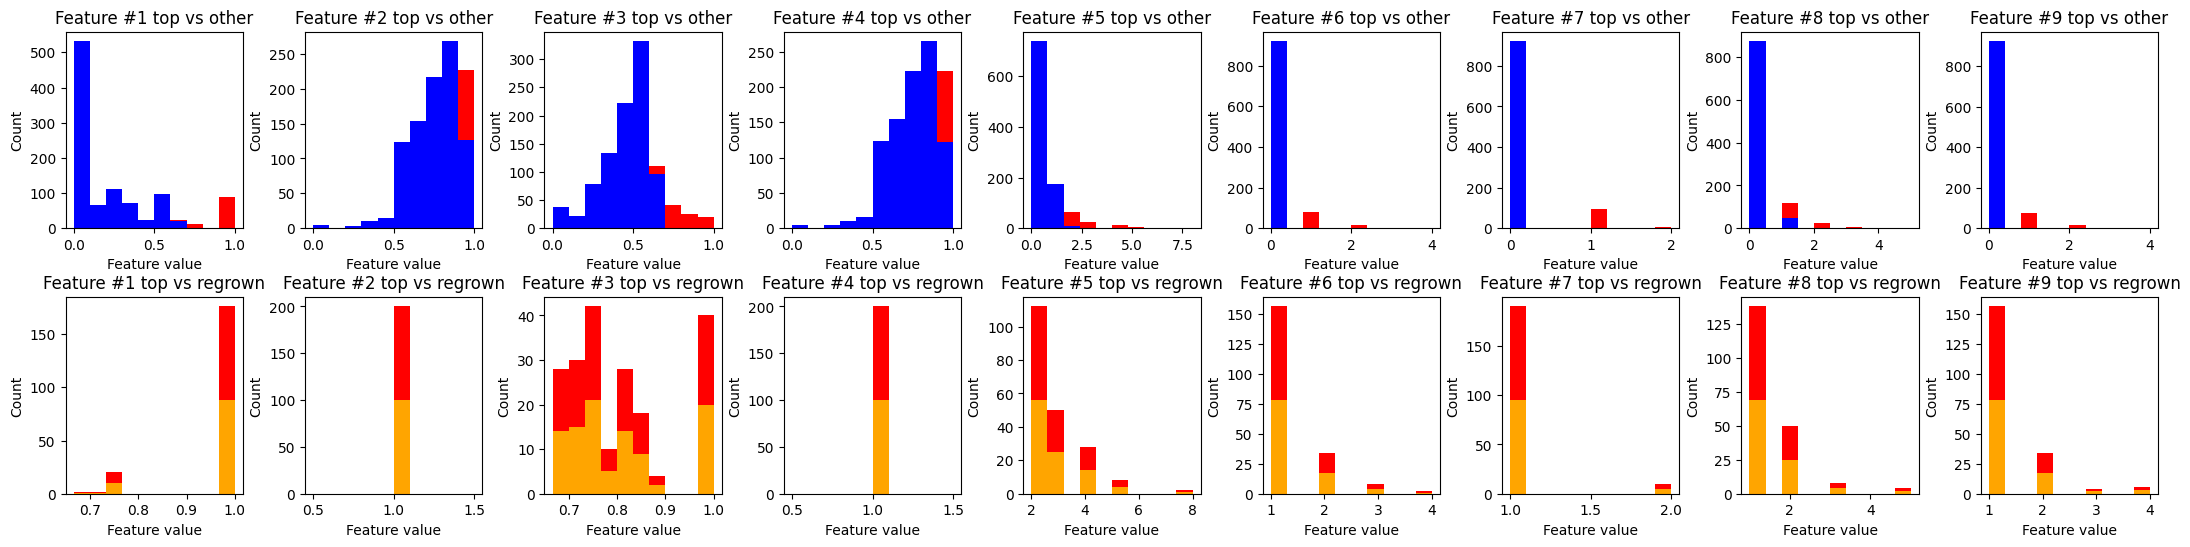

In [24]:
fig, axes = plt.subplots(2, 9, figsize=(27, 6))
syntethic_reals_df = syntethic_fitness_df[syntethic_fitness_df.real == 1]
k = 100

for index, target_feature in enumerate(relevant_feature_columns):
    top_k_real_df = syntethic_reals_df.nlargest(k, target_feature)
    other_real_df = syntethic_reals_df[~syntethic_reals_df.game_name.isin(top_k_real_df.game_name)]
    top_k_regrown_df = syntethic_fitness_df[np.logical_and(syntethic_fitness_df.original_game_name.isin(top_k_real_df.game_name),
        syntethic_fitness_df.game_name.isin(top_k_real_df.game_name))]

    real_comparison_ax = axes[0][index]
    real_comparison_ax.hist([other_real_df[target_feature], top_k_real_df[target_feature]], 
        color=['blue', 'red'], histtype='bar', stacked=True)
    real_comparison_ax.set_title(f'Feature #{index + 1} top vs other')
    real_comparison_ax.set_xlabel('Feature value')
    real_comparison_ax.set_ylabel('Count')

    regrowth_comparison_ax = axes[1][index]
    regrowth_comparison_ax.hist([top_k_regrown_df[target_feature], top_k_real_df[target_feature]], 
        color=['orange', 'red'], histtype='bar', stacked=True)
    # regrowth_comparison_ax.hist(, label='top', alpha=0.5, color='red', histtype='bar', stacked=True)
    regrowth_comparison_ax.set_title(f'Feature #{index + 1} top vs regrown')
    regrowth_comparison_ax.set_xlabel('Feature value')
    regrowth_comparison_ax.set_ylabel('Count')

plt.subplots_adjust(hspace=0.35, wspace=0.35)
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
index = 0

for target_feature in results_by_feature:
    results = results_by_feature[target_feature]
    weight_diffs = [r['weight_diff'] for r in results]
    ax = axes[index // 3][index % 3]
    ax.hist(weight_diffs, bins=5)
    ax.set_title(f'{target_feature} weight diffs\nP(max) = {np.mean([r["is_max_weight"] for r in results]):.2f}')
    ax.set_xlabel(f'Weight diff (target - max(others))')
    ax.set_ylabel('Count')
    index += 1

plt.subplots_adjust(hspace=0.35)
plt.show()

In [ ]:
def single_two_feature_parameter_recovery_experiment(df: pd.DataFrame, 
    positive_target_feature: str, negative_target_feature: str,
    param_grid: typing.Dict[str, typing.Any], target_feature_epsilon: float = 0,
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED,
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}
    
    syntethic_fitness_df = base_syntethic_df(df)

    if feature_columns is None:
        feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
    elif positive_target_feature not in feature_columns:
        raise ValueError(f'Positive target feature {positive_target_feature} not in feature_columns')
    elif negative_target_feature not in feature_columns:
        raise ValueError(f'Negative target feature {negative_target_feature} not in feature_columns')

    rng = np.random.default_rng(random_seed)

    unique_games = list(syntethic_fitness_df.original_game_name.unique())

    game_idxmaxes = []
    game_values = []
    for original_game in unique_games:
        pos_game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][positive_target_feature]
        neg_game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][negative_target_feature]
        diff = pos_game_col - neg_game_col
        idx = rng.choice(np.argwhere(diff.values == diff.values.max()).reshape(-1))
        game_idxmaxes.append(pos_game_col.index[idx])
        game_values.append(diff.values.max())

    syntethic_fitness_df.real = 0
    syntethic_fitness_df.loc[game_idxmaxes, 'real'] = 1
    syntethic_fitness_df.loc[game_idxmaxes, positive_target_feature] += target_feature_epsilon
    syntethic_fitness_df.loc[game_idxmaxes, negative_target_feature] -= target_feature_epsilon

    feature_combination_group_by = syntethic_fitness_df.groupby('original_game_name').apply(lambda df: df[positive_target_feature] - df[negative_target_feature]).groupby('original_game_name').max()
    
    for i, original_game in enumerate(unique_games):
        assert(feature_combination_group_by[original_game] == (syntethic_fitness_df.loc[game_idxmaxes[i], positive_target_feature] - syntethic_fitness_df.loc[game_idxmaxes[i], negative_target_feature]))  # type: ignore

    train_df, test_df = utils.train_test_split_by_game_name(syntethic_fitness_df, random_seed=random_seed)
    cv = cross_validate(train_df, feature_columns, param_grid, scoring_function=scoring_function,
        train_kwargs={'random_seed': random_seed, **train_kwargs}, model_kwargs=model_kwargs)
    best_model = cv.best_estimator_.named_steps['fitness'].model  # type: ignore
    weights = best_model.fc1.weight.detach().numpy().reshape(-1)

    pos_target_feature_index = feature_columns.index(positive_target_feature)
    pos_target_feature_is_max_weight = weights.argmax() == pos_target_feature_index
    pos_target_feature_is_min_weight = weights.argmin() == pos_target_feature_index
    pos_target_feature_weight_diff = weights[pos_target_feature_index] - weights[np.arange(len(weights)) != pos_target_feature_index].max()

    neg_target_feature_index = feature_columns.index(negative_target_feature)
    neg_target_feature_is_max_weight = weights.argmax() == neg_target_feature_index
    neg_target_feature_is_min_weight = weights.argmin() == neg_target_feature_index
    neg_target_feature_weight_diff = weights[neg_target_feature_index] - weights[np.arange(len(weights)) != neg_target_feature_index].min()

    return {
        'pos_target_feature': positive_target_feature,
        'neg_target_feature': negative_target_feature,
        'random_seed': random_seed,
        'pos_is_max_weight': pos_target_feature_is_max_weight,
        'pos_is_min_weight': pos_target_feature_is_min_weight,
        'pos_weight_diff': pos_target_feature_weight_diff,
        'neg_is_max_weight': neg_target_feature_is_max_weight,
        'neg_is_min_weight': neg_target_feature_is_min_weight,
        'neg_weight_diff': neg_target_feature_weight_diff,
        'best_params': cv.best_params_,
        'best_score': cv.best_score_,
        'target_feature_epsilon': target_feature_epsilon,
    }
    

DEFAULT_LEGEND_KWARGS = dict(loc='upper left', bbox_to_anchor=(1.05, 1.425))
DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(hspace=0.35, wspace=0.3)
    
def plot_two_feature_parameter_recovery_experiment_results(
    results_by_feature: typing.Dict[typing.Tuple[str, str], typing.List[typing.Dict[str, typing.Any]]], 
    feature_columns: typing.List[str], flip_features: bool = False,
    layout: typing.Tuple[int, int] = (2, 5), figsize: typing.Tuple[int, int] = (20, 10),
    title: typing.Optional[str] = None, colormap: str = 'tab10',
    legend_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LEGEND_KWARGS,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    ):

    cmap = plt.get_cmap(colormap)  # type: ignore
    fig, axes = plt.subplots(*layout, figsize=figsize)
    index = 0

    for target_feature in feature_columns:
        positive_keys = [k for k in results_by_feature.keys() if k[0] == target_feature]
        negative_keys = [k for k in results_by_feature.keys() if k[1] == target_feature]

        positive_results = [results_by_feature[k] for k in positive_keys]
        negative_results = [results_by_feature[k] for k in negative_keys]

        positive_weight_diffs = [r['pos_weight_diff'] for r in itertools.chain(*positive_results)]
        negative_weight_diffs = [r['neg_weight_diff'] for r in itertools.chain(*negative_results)]

        if flip_features:
            max_key = 'neg_is_max_weight'
            min_key = 'pos_is_min_weight'
        else:
            max_key = 'pos_is_max_weight'
            min_key = 'neg_is_min_weight'

        feature_is_max_weight = [r[max_key] for r in itertools.chain(*positive_results)]
        feature_is_min_weight = [r[min_key] for r in itertools.chain(*negative_results)]

        ax = axes[index // 5][index % 5]
        positive_color, negative_color = cmap(0), cmap(1)
        if flip_features:
            positive_color, negative_color = negative_color, positive_color

        ax.hist(positive_weight_diffs, color=positive_color, label='Positive feature\nregression weight')
        ax.hist(negative_weight_diffs, color=negative_color, label='Negative feature\nregression weight')

        max_mean, min_mean = np.mean(feature_is_max_weight), np.mean(feature_is_min_weight)
        ax.set_title(f'{target_feature} weight diffs\nP(min) = {min_mean:.2f} | P(max) = {max_mean:.2f}')
        ax.set_xlabel(f'Weight diff (target - max/min(others))')
        ax.set_ylabel('Count')
        index += 1

    if title:
        fig.suptitle(title)

    plt.legend(**legend_kwargs)
    plt.subplots_adjust(**subplot_adjust_params)
    plt.show()

In [ ]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,]   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]

two_feature_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed))


In [ ]:
plot_two_feature_parameter_recovery_experiment_results(two_feature_results_by_feature, all_feature_columns)

In [ ]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,],
    'fitness__margin': [1, 2, 4],   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = {'output_activation': nn.Identity()}
train_kwargs = {'loss_function': utils.fitness_hinge_loss}

two_feature_hinge_loss_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_hinge_loss_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed, 
            scoring_function=utils.evaluate_fitness_flipped_sign, model_kwargs=model_kwargs, train_kwargs=train_kwargs))


In [ ]:
plot_two_feature_parameter_recovery_experiment_results(
    two_feature_hinge_loss_results_by_feature, all_feature_columns, flip_features=True,
)

In [ ]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,]   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = {'output_activation': nn.Identity()}
train_kwargs = {'loss_function': utils.fitness_log_loss}

two_feature_log_loss_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_log_loss_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed, 
            scoring_function=utils.evaluate_fitness_flipped_sign, model_kwargs=model_kwargs, train_kwargs=train_kwargs))


In [ ]:
plot_two_feature_parameter_recovery_experiment_results(
    two_feature_log_loss_results_by_feature, all_feature_columns, flip_features=True,
)

In [ ]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,],
    'fitness__margin': [1, 2, 4],   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = {'output_activation': nn.Identity()}
train_kwargs = {'loss_function': utils.fitness_square_square_loss}

two_feature_square_square_loss_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_square_square_loss_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed, 
            scoring_function=utils.evaluate_fitness_flipped_sign, model_kwargs=model_kwargs, train_kwargs=train_kwargs))


In [ ]:
plot_two_feature_parameter_recovery_experiment_results(
    two_feature_square_square_loss_results_by_feature, all_feature_columns, flip_features=True,
)

## Debugging thoughts about these new losses
* Plot my loss implementations to make sure they behave as expected
* Verify my scoring function works and the model returned is actually the best one
* Try the square-square loss as well
* Cross validate over other margins?